In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline

#So we have removed approximately 12 features
# Starting Gausian Mixture Model implementation
import matplotlib as mpl
import itertools
from sklearn import mixture
from scipy import linalg

DATA_DIR = "NSL_KDD_Dataset"
train_nsl_kdd_dataset_path = "KDDTrain+.txt"
test_nsl_kdd_dataset_path = "KDDTest+.txt"
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])
categoricalColumns = col_names[[1,2,3]]
binaryColumns = col_names[[6, 11, 13, 14, 20, 21]]
numericColumns = col_names[list(set(range(41)) - set([1,2,3]) - set([6, 11, 13, 14, 20, 21]))]

In [2]:
train = pd.read_csv(os.path.join(DATA_DIR, train_nsl_kdd_dataset_path), header=None)
train.drop([42], 1, inplace=True)
train.columns = col_names
train_shape = train.shape[0]
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [3]:
test = pd.read_csv(os.path.join(DATA_DIR, test_nsl_kdd_dataset_path), header=None)
test.drop([42], 1, inplace=True)
test.columns = col_names
test_shape = test.shape[0]
print(test.shape)
test.head()

(22544, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


In [4]:
# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',
   
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

In [5]:
mergedDataSet = pd.concat([train, test]).reset_index(drop=True)
# Performing all the encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
enc = LabelEncoder()
#
def encodeCategorical(ser):
    return enc.fit_transform(ser)

mergedDataSet['service'] = encodeCategorical(mergedDataSet['service'])
mergedDataSet['flag'] = encodeCategorical(mergedDataSet['flag'])
mergedDataSet = pd.get_dummies(mergedDataSet, columns=['protocol_type'])
mergedDataSet['labelsMapped'] = mergedDataSet['labels'].map(lambda x: attack_dict[x])

scaler = MinMaxScaler()
mergedDataSet[numericColumns] = scaler.fit_transform(mergedDataSet[numericColumns])

In [6]:
testDataSet = mergedDataSet.loc[train.shape[0]:,:]
trainDataSet = mergedDataSet.loc[:train.shape[0], :]

In [7]:
#binaryColumns = list(binaryColumns) + list(categoricalColumns[1:]) + [u'protocol_type_icmp', u'protocol_type_tcp', u'protocol_type_udp']
import sys
from collections import OrderedDict
e = sys.float_info.epsilon
def calAttributeRatio(df, numericColumns,binaryColumns):
    denom = {}
    ar = {}
    for col in numericColumns:
        denom[col] = df[col].mean();

    for col in numericColumns:
        ar[col] = df.fillna(value=0.0).groupby('labelsMapped')[[col]].mean().max().values[0]/(denom[col])

    def test_sum(series):
        return (series.sum()/(len(series)-series.sum()+e))
    for col in binaryColumns:
        groups = df.groupby('labelsMapped')[[col]]
        ar[col] = groups.aggregate([test_sum]).max().values[0]
    return ar

ar_op = calAttributeRatio(trainDataSet,numericColumns,binaryColumns)
#print(OrderedDict(sorted(ar_op.items(), key=lambda v: -v[1])))
def selectTopFeaturesByAR(ar_op, min_ar):
    return [c for c in ar_op.keys() if ar_op[c]>=min_ar]
selectedFeatures = selectTopFeaturesByAR(ar_op,1.00)
train_processed_selectedFeatures = pd.concat([trainDataSet[selectedFeatures], trainDataSet[['labelsMapped', u'protocol_type_icmp', u'protocol_type_tcp', u'protocol_type_udp', u'service', u'flag']]], axis=1)
train_processed_selectedFeatures.head()

/Users/shashankbhushan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


OrderedDict([('num_shells', 326.11612426035521), ('urgent', 173.04120879120882), ('num_file_creations', 62.234118951224417), ('num_failed_logins', 46.038921882138006), ('hot', 40.774840493730707), ('logged_in', 10.569767441860465), ('dst_bytes', 9.1549270284905191), ('src_bytes', 8.4641313944604359), ('duration', 7.2258865173545788), ('dst_host_srv_diff_host_rate', 5.7569263820766396), ('dst_host_diff_srv_rate', 4.8373524734680329), ('num_access_files', 4.6949165175909036), ('dst_host_same_src_port_rate', 4.3931152520736072), ('num_compromised', 4.3385737152153352), ('diff_srv_rate', 4.0690870488934809), ('dst_host_srv_rerror_rate', 3.6677075035125544), ('srv_rerror_rate', 3.6675306730359276), ('rerror_rate', 3.6453737959679429), ('dst_host_rerror_rate', 3.2793738892262856), ('srv_diff_host_rate', 3.0815901722227639), ('wrong_fragment', 2.7428583870405854), ('dst_host_srv_serror_rate', 2.6731226120858391), ('srv_serror_rate', 2.6432097487171315), ('serror_rate', 2.6310182415379524), ('

,num_access_files,src_bytes,srv_count,num_compromised,rerror_rate,urgent,dst_host_same_srv_rate,duration,srv_rerror_rate,srv_serror_rate,...,dst_host_srv_rerror_rate,srv_diff_host_rate,num_failed_logins,dst_host_serror_rate,labelsMapped,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service,flag
0,0.0,3.558064e-07,0.003914,0.0,0.0,0.0,0.17,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,normal,0,1,0,20,9
1,0.0,1.057999e-07,0.001957,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,normal,0,0,1,44,9
2,0.0,0.000000e+00,0.011742,0.0,0.0,0.0,0.10,0.0,0.0,1.0,...,0.00,0.00,0.0,1.00,DoS,0,1,0,49,5
3,0.0,1.681203e-07,0.009785,0.0,0.0,0.0,1.00,0.0,0.0,0.2,...,0.01,0.00,0.0,0.03,normal,0,1,0,24,9
4,0.0,1.442067e-07,0.062622,0.0,0.0,0.0,1.00,0.0,0.0,0.0,...,0.00,0.09,0.0,0.00,normal,0,1,0,24,9


In [8]:
#removing the columns from test data set
test_processed_selectedFeatures = testDataSet[train_processed_selectedFeatures.columns]

In [9]:
from sklearn.cluster import KMeans

In [23]:
sse_dict = {}
num_clusters = 20
for i in range(1,num_clusters-1):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(train_processed_selectedFeatures.drop(['labelsMapped'], 1))
    labels = kmeans.labels_
    sse_val = kmeans.inertia_
    sse_dict[i] = sse_val

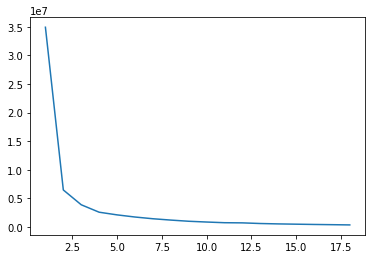

In [24]:

import matplotlib.pylab as plt

lists = sorted(sse_dict.items())

x, y = zip(*lists)

plt.plot(x, y)
plt.show()
num_clusters = 5

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [50]:
train_processed_selectedFeatures['binaryLabel'] = train_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1)
test_processed_selectedFeatures['binaryLabel'] = test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1)

def kmeans_run(trainData, testData, clusters, failureLabel, toDrop):
    trainData = trainData.copy()
    kmeans_fin = KMeans(n_clusters=clusters, random_state=0).fit(trainData.drop(toDrop + [failureLabel], 1))
    labels_fin_test = kmeans_fin.predict(testData.drop(toDrop + [failureLabel], 1))
    labels_fin = kmeans_fin.predict(trainData.drop(toDrop + [failureLabel], 1))
    trainData['knn_l'] = labels_fin
    cluster_list = {}
    for i in range(clusters):
        lis = trainData[trainData['knn_l'] == i][failureLabel]
        cluster_list[i] = lis.mode()[0]
    pred_y = pd.Series(labels_fin_test).map(cluster_list)
    if trainData[failureLabel].unique().shape[0] != 2:
        precisionScore = precision_score(testData[failureLabel], pred_y, average = "weighted")
        recallScore = recall_score(testData[failureLabel], pred_y, average = "weighted")
    else:
        precisionScore = precision_score(testData[failureLabel], pred_y)
        recallScore = recall_score(testData[failureLabel], pred_y)
    return accuracy_score(testData[failureLabel], pred_y), precisionScore, recallScore ,pd.crosstab(testData[failureLabel].values, pred_y.values, rownames=['True'], colnames=['Predicted'], margins=True), kmeans_fin
    
    
num_clusters = 5
accuracy, precision, recall, conf_mat, kmeansMdl = kmeans_run(train_processed_selectedFeatures, test_processed_selectedFeatures, num_clusters, 'labelsMapped', ['binaryLabel'])
print "Accuracy:", accuracy, "Precision:", precision, "Recall:",  recall
conf_mat

/Users/shashankbhushan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Accuracy: 0.571105393896 Precision: 0.437114751817 Recall: 0.571105393896


Predicted,DoS,normal,All
True,,,
DoS,4788,2670,7458
Probe,1890,531,2421
R2L,1677,1077,2754
U2R,170,30,200
normal,1624,8087,9711
All,10149,12395,22544


In [51]:
#Checking for a binary model
num_clusters = 2
accuracy, precision, recall, confMat, kmeansMdl = kmeans_run(train_processed_selectedFeatures, test_processed_selectedFeatures, num_clusters, 'binaryLabel', ['labelsMapped'])
print 'Binary Model accuracy is', accuracy, "Precision", precision, "Recall:",  recall
confMat

Binary Model accuracy is 0.729817246274 Precision 0.837505006007 Recall: 0.6518351126


Predicted,0,1,All
True,,,
0,8088,1623,9711
1,4468,8365,12833
All,12556,9988,22544


In [11]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
#dbscan = DBSCAN(eps=3, algorithm = 'kd_tree', min_samples=5)    
dbscan = DBSCAN(eps=4.5, algorithm = 'kd_tree',min_samples=5)    #- 750   
#dbscan = DBSCAN(eps=5.25, algorithm = 'kd_tree',min_samples=5)    - 500
#print(data)
dbscan.fit(train_processed_selectedFeatures.drop(['labelsMapped'], 1)) 

DBSCAN(algorithm='kd_tree', eps=4.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [53]:
from sklearn import metrics

In [12]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(train_processed_selectedFeatures['labelsMapped'], labels))
print("Completeness: %0.3f" % metrics.completeness_score(train_processed_selectedFeatures['labelsMapped'], labels))
print("V-measure: %0.3f" % metrics.v_measure_score(train_processed_selectedFeatures['labelsMapped'], labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(train_processed_selectedFeatures['labelsMapped'], labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(train_processed_selectedFeatures['labelsMapped'], labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(train_processed_selectedFeatures.drop(['labelsMapped', 'binaryLabel'], 1), labels))

Estimated number of clusters: 1
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000


## Starting with GMM

In [15]:


lowest_bic = np.infty
bic = []
X = train_processed_selectedFeatures.drop(['labelsMapped'], 1)
n_components_range = range(1, 20)
cv_types = ['diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

NameError: name 'plt' is not defined

In [118]:
def getAssignment(cluster_probabilities, cluster_list):
    sumWeightedProb = np.dot(cluster_probabilities, cluster_list)
    return np.argmax(sumWeightedProb)

In [130]:
def gmm_run(trainData, testData, components, covariance_type, failureLabel, toDrop):
    trainData = trainData.copy()
    gmm = mixture.GaussianMixture(n_components=components, covariance_type=covariance_type)
    gmm = gmm.fit(trainData.drop(toDrop + [failureLabel], 1))
    labels_fin_test = gmm.predict(testData.drop(toDrop + [failureLabel], 1))
    labels_fin = gmm.predict(trainData.drop(toDrop + [failureLabel], 1))
    trainData['gmm_l'] = labels_fin
    cluster_list = []
    cluster_list_old = {}
    attackTypes = train_data[failureLabel].unique()
    for i in range(components):
        lis = train_data[train_data['gmm_l'] == i][failureLabel]
        probDist = []
        for acc in attackTypes:
            probDist.append(float(lis[lis == acc].shape[0])/lis.shape[0])
        cluster_list.append(np.array(probDist))
        cluster_list_old[i] = lis.mode()[0]
    cluster_list = np.array(cluster_list)
    labels_fin_test_proba = gmm.predict_proba(testData.drop(toDrop + [failureLabel], 1))  
        
    pred_y = pd.Series(labels_fin_test).map(cluster_list_old)
    pred_y_Assignment = map(lambda x: attackTypes[getAssignment(x, cluster_list)], labels_fin_test_proba)
    if trainData[failureLabel].unique().shape[0] != 2:
        precisionScore = precision_score(testData[failureLabel], pred_y, average = "weighted")
        recallScore = recall_score(testData[failureLabel], pred_y, average = "weighted")
        
        precisionScore_assignment = precision_score(testData[failureLabel], pred_y_Assignment, average = "weighted")
        recallScore_assignment = recall_score(testData[failureLabel], pred_y_Assignment, average = "weighted")
    else:
        precisionScore = precision_score(testData[failureLabel], pred_y)
        recallScore = recall_score(testData[failureLabel], pred_y)
        
        precisionScore_assignment = precision_score(testData[failureLabel], pred_y_Assignment)
        recallScore_assignment = recall_score(testData[failureLabel], pred_y_Assignment)
    return accuracy_score(testData[failureLabel], pred_y), precisionScore, recallScore, pd.crosstab(testData[failureLabel].values, pred_y.values, rownames=['True'], colnames=['Predicted'], margins=True), accuracy_score(testData[failureLabel], pred_y_Assignment), precisionScore_assignment, recallScore_assignment, gmm

components = 17
covariance_type = 'full'
accuracy, precision, recall, confMat_gmm, accuracy_assign, precision_assign, recall_assign, gmmMdl = gmm_run(train_processed_selectedFeatures, test_processed_selectedFeatures, components, covariance_type,'labelsMapped', ['binaryLabel'])
print "Accuracy:", accuracy, "Precision:", precision, "Recall:",  recall
print "Accuracy:", accuracy_assign, "Precision:", precision_assign, "Recall:",  recall_assign
confMat_gmm

0        normal
1        normal
2        normal
3           DoS
4           DoS
5        normal
6        normal
7           DoS
8        normal
9           DoS
10       normal
11       normal
12       normal
13       normal
14       normal
15       normal
16       normal
17       normal
18        Probe
19       normal
20       normal
21        Probe
22       normal
23       normal
24       normal
25          DoS
26       normal
27       normal
28          DoS
29        Probe
          ...  
22514    normal
22515       DoS
22516    normal
22517    normal
22518    normal
22519    normal
22520     Probe
22521     Probe
22522     Probe
22523    normal
22524    normal
22525       DoS
22526    normal
22527    normal
22528       DoS
22529    normal
22530       DoS
22531    normal
22532    normal
22533    normal
22534    normal
22535    normal
22536    normal
22537    normal
22538       DoS
22539    normal
22540    normal
22541     Probe
22542     Probe
22543       DoS
Length: 22544, dtype: ob

Predicted,DoS,Probe,normal,All
True,,,,
DoS,2564,671,4223,7458
Probe,1094,939,388,2421
R2L,656,500,1598,2754
U2R,40,1,159,200
normal,211,2057,7443,9711
All,4565,4168,13811,22544


In [120]:
train_data = train_processed_selectedFeatures.copy()
test_data = test_processed_selectedFeatures.copy()
train_data['binaryLabel'] = train_data['labelsMapped'].map(lambda x: 0 if x == "normal" else 1)
test_data['binaryLabel'] = test_data['labelsMapped'].map(lambda x: 0 if x == "normal" else 1)
labels_fin_test = gmmMdl.predict(test_data.drop(['labelsMapped'] + ['binaryLabel'], 1))
labels_fin = gmmMdl.predict(train_data.drop(['labelsMapped'] + ['binaryLabel'], 1))
train_data['gmm_l'] = labels_fin
cluster_list = []
attackTypes = train_data['binaryLabel'].unique()
for i in range(components):
    lis = train_data[train_data['gmm_l'] == i]['binaryLabel']
    probDist = []
    for acc in attackTypes:
        probDist.append(float(lis[lis == acc].shape[0])/lis.shape[0])
    cluster_list.append(np.array(probDist))
cluster_list = np.array(cluster_list)
labels_fin_test_proba = gmmMdl.predict_proba(test_data.drop(['labelsMapped'] + ['binaryLabel'], 1))
pred_y = map(lambda x: getAssignment(x, cluster_list), labels_fin_test_proba)

In [62]:
print accuracy_score(test_data['binaryLabel'], pred_y)
print precision_score(test_data['binaryLabel'], pred_y)
print recall_score(test_data['binaryLabel'], pred_y)

0.698012775018
0.919509817574
0.514532845009


In [63]:
pd.crosstab(test_data['binaryLabel'].values, pred_y.values, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,9133,578,9711
1,6230,6603,12833
All,15363,7181,22544


In [122]:
print accuracy_score(test_data['binaryLabel'], pred_y)
print precision_score(test_data['binaryLabel'], pred_y)
print recall_score(test_data['binaryLabel'], pred_y)

0.698012775018
0.919509817574
0.514532845009


In [100]:
import numpy as np
temp_a = np.array([np.array([-3, 4]), np.array([2, 1])])
temp_b = np.array([1, 1])

In [124]:
attackTypes[1]

1

In [115]:
temp_a.shape

(2, 2)